In [3]:
import logging
from typing import Optional, Type
import matplotlib as mpl
import json
import sys
import numpy as np
import tables
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [4]:
from phd.thunderstorm.dwyer_plots import polar_theta_energy
from phd.utils.hep_tools import PDGID
logging.root.setLevel(logging.INFO)

In [5]:
from tables import File, Group, Table
path = "/home/zelenyy/data/thunderstorm/test_probability_dwyer/result.hdf5"

In [18]:
@dataclass
class Histogram2D:
    xbins : np.ndarray
    ybins : np.ndarray
    data : np.ndarray
    
    
    @staticmethod
    def from_file(h5file: File, group: Group, number: int = 0):
        bins_x = h5file.get_node(group, "xbins").read()
        bins_y = h5file.get_node(group, "ybins").read()
        table = h5file.get_node(group, "histByEvent")
        data = table.read(number)['histogram'][0]
        return Histogram2D(bins_x, bins_y, data)
    
    @staticmethod
    def plot(histogram : "Histogram2D"):
        fig, ax = plt.subplots()
        xmin, xmax = histogram.xbins[0], histogram.xbins[-1]
        ymin, ymax = histogram.ybins[0], histogram.ybins[-1]
        ax.matshow(histogram.data)
        # xticks = ax.get_xticks()
        # ax.set_xticks(list(map(
        #     lambda x: histogram.xbins[int(x)],
        #     xticks
        # )))
        # 
        # yticks = ax.get_yticks()
        # ax.set_yticks(list(map(
        #     lambda x: histogram.ybins[int(x)],
        #     yticks
        # )))
        
    
    

In [10]:
with tables.open_file(path) as h5file:
    group = h5file.get_node(h5file.root, "sim0001/histogram/gamma_low")
    hist = Histogram2D.from_file(h5file, group)

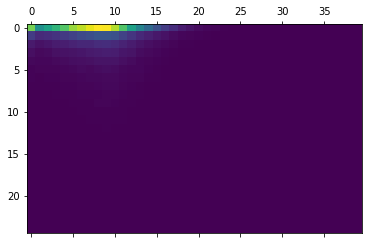

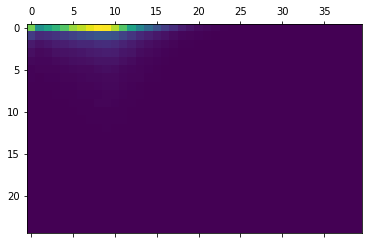

In [21]:
with tables.open_file(path) as h5file:
    # group = h5file.get_node(h5file.root, "sim0001/histogram/gamma_low")
    group = h5file.get_node(h5file.root, "sim0001/histogram/gamma_high")
    # group = h5file.get_node(h5file.root, "sim0001/histogram/gamma_low")
    # group = h5file.get_node(h5file.root, "sim0001/histogram/gamma_low")
    for i in range(2):
        hist = Histogram2D.from_file(h5file, group, i)
        Histogram2D.plot(hist)



In [ ]:

class WeightHistogramm:
    def __init__(self, bins_x, bins_y, data):
        self.bins_x = bins_x
        self.bins_y = bins_y
        self.data = data
    
    def get_weight(self, x, y) -> float:
        xc = np.argmax(self.bins_x>x) - 1
        yc = np.argmax(self.bins_y>y) - 1
        return self.data[xc,yc]
    
    @staticmethod
    def from_file(h5file: File, group: Group, tracking_table: Table, particle : PDGID):
        bins_x = h5file.get_node(group, "xbins").read()
        bins_y = h5file.get_node(group, "ybins").read()
        table = h5file.get_node(group, "histByEvent")
        data = table.read(table.nrows-1)['histogram'][0]
        
        energy_min = np.min(bins_x)
        energy_max = np.max(bins_x)
        
        condition="(energy > {}) & (energy <= {}) & (particle == {})".format(energy_min, energy_max, particle.value)
        logging.debug("Using condition to selection: " + condition)
        data_tracking = tracking_table.read_where(condition)
        
        accepted = np.histogram2d(data_tracking["energy"], data_tracking["z"], bins=(bins_x, bins_y))[0]
        weight = data/accepted
        return WeightHistogramm(bins_x, bins_y, weight)



@dataclass
class HistDispatcher:
    gamma_low : WeightHistogramm
    gamma_high: WeightHistogramm
    electron_low: WeightHistogramm
    electron_high: WeightHistogramm
    
    def get_hist(self, particle) -> Optional[WeightHistogramm]:
        """
        PDGID
        electron = 11
        positron = -11
        gamma = 22
        :param particle: 
        :return: 
        """
        if particle["particle"] == PDGID.GAMMA.value:
            if particle["energy"] < 1.0:
                return self.gamma_low
            else:
                return self.gamma_high
        elif particle["particle"] == PDGID.ELECTRON.value:
            if particle["energy"] < 1.0:
                return self.electron_low
            else:
                return self.electron_high
        elif particle["particle"] == PDGID.ELECTRON.value:
            return None
        else:
            return None
    @staticmethod
    def from_file(h5file, group):
        
        tracking_table = h5file.get_node(group, "treeTracking")
        
        group_hist = h5file.get_node(group, "histogram")
        group_gamma_low = h5file.get_node(group_hist, "gamma_low")
        gamma_low = WeightHistogramm.from_file(h5file, group_gamma_low, tracking_table, PDGID.GAMMA)
        
        group_gamma_high = h5file.get_node(group_hist, "gamma_high")
        gamma_high = WeightHistogramm.from_file(h5file, group_gamma_high, tracking_table, PDGID.GAMMA)

        group_electron_low = h5file.get_node(group_hist, "electron_low")
        electron_low = WeightHistogramm.from_file(h5file, group_electron_low, tracking_table, PDGID.ELECTRON)        

        group_electron_high = h5file.get_node(group_hist, "electron_high")
        electron_high = WeightHistogramm.from_file(h5file, group_electron_high, tracking_table, PDGID.ELECTRON)
        
        return HistDispatcher(gamma_low, gamma_high, electron_low, electron_high)

In [21]:
with tables.open_file(path) as h5file:
    group =h5file.get_node(h5file.root, "sim0001")
    hist_dispatcher = HistDispatcher.from_file(h5file, group)
    

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
def find_chain(data, parent_id):
    result = []
    parent_indx = np.where(data["id"] == parent_id)[0][0]
    next_parent_id = data[parent_indx]["parent_id"]
    result.append(data[parent_indx])
    if next_parent_id == 0:
        return []
    result += find_chain(data, next_parent_id) 
    return result

def count_track_weight(data, data_final, hist_dispatcher: HistDispatcher):
    weights = []
    for final in data_final:
        chain = find_chain(data, final["parent_id"])
        weight = 1
        for item in chain:
            if item["particle"] == PDGID.POSITRON.value:
                continue
            hist = hist_dispatcher.get_hist(item)
            weight *= hist.get_weight(item["energy"], item["z"])
        weights.append(weight)
    return weights


In [25]:
with tables.open_file(path) as h5file:
    data = h5file.get_node(h5file.root, "sim0001/treeTracking").read()
    data_gamma =h5file.get_node(h5file.root, "sim0001/gammaSeed").read()

In [30]:
def plot_data(data):
    plt.subplot("221")
    plt.hist(data['energy'])
    plt.subplot("222")
    plt.hist(data['z'])
    # plt.subplot("223")
    # plt.hist(data['energy'])

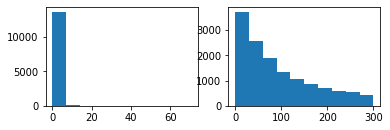

In [31]:
plot_data(data_gamma)

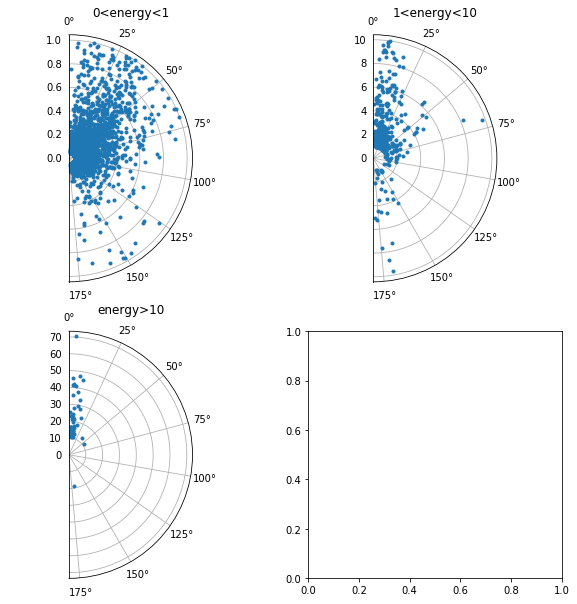

In [44]:
polar_theta_energy(data_gamma, boundaries=(0, 1, 10))

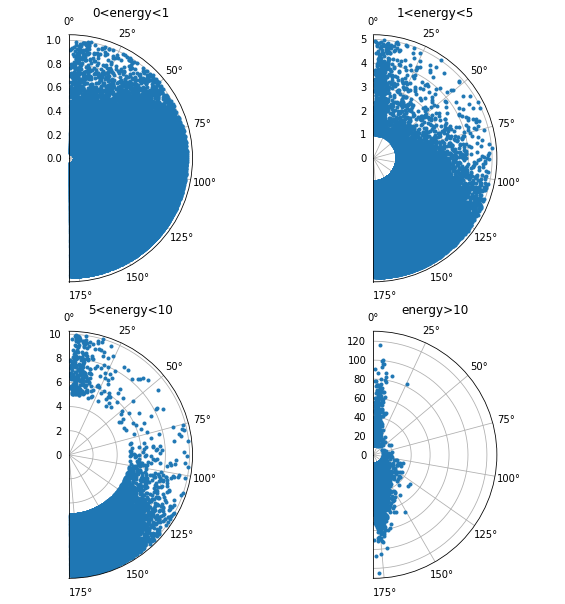

In [47]:
polar_theta_energy(data, boundaries=(0, 1, 5, 10))

In [ ]:
chain = find_chain(data, data_gamma["parent_id"][0])

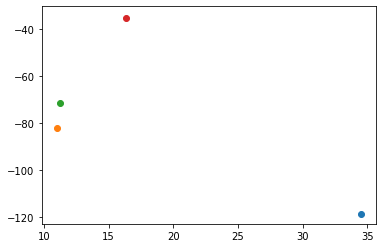

In [27]:
for item in chain:
    plt.scatter(item["radius"],item["z"])

In [28]:
gamma_weights = count_track_weight(data, data_gamma, hist_dispatcher)

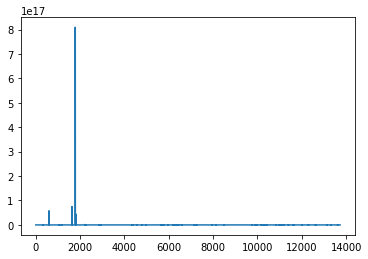

In [29]:
plt.plot(gamma_weights)

In [53]:
data.dtype

dtype([('id', '<i4'), ('parent_id', '<i4'), ('particle', '<i4'), ('zero', '<i4'), ('energy', '<f8'), ('theta', '<f8'), ('radius', '<f8'), ('z', '<f8')])

In [ ]:
hist_dispatcher.gamma_low.data

In [6]:
with tables.open_file(path) as h5file:
    table =h5file.get_node(h5file.root, "sim0001/histDwyer2003/electron_high/xbins")
    print(repr(table.attrs))

/sim0001/histDwyer2003/electron_high/xbins._v_attrs (AttributeSet), 6 attributes:
   [CLASS := 'ARRAY',
    FLAVOR := 'numpy',
    TITLE := '',
    VERSION := '2.4',
    type := 'energy',
    unit := 'MeV']


In [21]:
condition="(energy > 1) & (energy <= 5) & (particle == 22)"
with tables.open_file(path) as h5file:
    table =h5file.get_node(h5file.root, "sim0001/TreeTracking")
    data = table.read_where(condition)
    print(data.dtype)

[('id', '<i4'), ('parent_id', '<i4'), ('particle', '<i4'), ('zero', '<i4'), ('energy', '<f8'), ('theta', '<f8'), ('radius', '<f8'), ('z', '<f8')]
